In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask

In [2]:
set_plotting_style()

In [3]:
try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

In [240]:
def make_df(fname):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/BS_(x|y)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError)$/",
                     "run","luminosityBlock",
                    ],outputtype=dict,namedecode="ascii")
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
        & (arrs["DV_rho"]>1.0).any()
    )

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv)
    df["angle3dmumu"] = np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    df["maxabsdxy"] = np.maximum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["minabsdxy"] = np.minimum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    # skim more
    df = df.query("(cosphi > 0.) and (Muon1_charge != Muon2_charge) and (DV_xyErrorMax < 0.05)")
    return df
    
df_data = pd.concat(
    map(make_df,glob.glob(
        "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_vtestskim1cm/*.root"
    ))
).reset_index(drop=True)
df_mc = make_df("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau50mm.root").reset_index(drop=True)

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in arccos


In [4]:
# if True:
if False:
    df_data.to_pickle("data/df_data.pkl")
    df_mc.to_pickle("data/df_mc.pkl")
else:
    df_data = pd.read_pickle("data/df_data.pkl")
    df_mc = pd.read_pickle("data/df_mc.pkl")

In [5]:
df_mc.head()

,nDV,nPV,nPVM,nMuon,nGenPart,nGenMuon,pass_skim,pass_l1,pass_fiducialgen,MET_pt,...,DV_redchi2,DV_xyErrorMax,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt,maxabsdxy,minabsdxy,maxdxy,mindxy
0,1,11,2,2,9,2,True,True,True,36.795246,...,0.438167,0.005694,1.066454,1.358333,0.016510,0.020892,1.349426,0.186607,1.349426,-0.186607
1,1,12,2,2,17,4,True,True,True,38.700554,...,0.000847,0.002386,1.224413,0.528511,0.013034,0.010552,1.117955,0.848242,0.848242,-1.117955
2,1,14,1,2,11,2,True,True,True,36.773937,...,0.000963,0.001972,1.040387,0.464748,0.015950,0.015825,4.317966,2.775682,4.317966,-2.775682
3,1,16,8,2,10,2,True,True,True,3.516805,...,0.609632,0.002097,0.899231,0.928609,0.012259,0.010641,2.645410,1.110090,2.645410,-1.110090
4,1,8,1,2,11,2,True,True,True,3.666943,...,0.484172,0.002047,0.792309,0.441621,0.013987,0.010255,5.296400,4.872239,4.872239,-5.296400


In [245]:
df.columns

Index(['nDV', 'nPV', 'nPVM', 'nMuon', 'nGenPart', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_fiducialgen', 'MET_pt', 'MET_phi', 'BS_x', 'BS_y',
       'Muon1_pt', 'Muon2_pt', 'Muon1_eta', 'Muon2_eta', 'Muon1_phi',
       'Muon2_phi', 'Muon1_m', 'Muon2_m', 'Muon1_trackIso', 'Muon2_trackIso',
       'Muon1_chi2', 'Muon2_chi2', 'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge',
       'Muon2_charge', 'Muon1_dxy', 'Muon2_dxy', 'Muon1_nValidMuonHits',
       'Muon2_nValidMuonHits', 'Muon1_nValidPixelHits',
       'Muon2_nValidPixelHits', 'Muon1_nMatchedStations',
       'Muon2_nMatchedStations', 'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_trk_qoverp', 'Muon2_trk_qoverp',
       'Muon1_dxyError', 'Muon2_dxyError', 'Muon1_trk_qoverpError',
       'Muon2_trk_qoverpError', 'Muon1_vx', 'Muon2_vx', 'Muon1_vy', 'Muon2_vy',
       'Muon1_vz', 'Muon2_vz', 'Muon1_dxyCorr', 'Muon2_dxyCorr', 'DV_x',


In [248]:
plotdir = "plots_split_v2/"
os.system("mkdir -p {}".format(plotdir))

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    ["near pix.",lambda df:  df["DV_inPixelRectangles"]],
    ["away pix.",lambda df: ~df["DV_inPixelRectangles"]],
],split_label = "splitpixel"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"dimuon $p_T$<20",lambda df: (df["dimuon_pt"]<20)],
    [r"20<dimuon $p_T$<50",lambda df:  (df["dimuon_pt"]<50) & (df["dimuon_pt"]>20)],
    [r"dimuon $p_T$>50",lambda df:  (df["dimuon_pt"]>50)],
],split_label = "splitpt"))

selinfos.append(dict(vsels=[
    [r"1.0<DV $\rho$<3.6",lambda df:  (np.abs(df["DV_rhoCorr"])<3.6) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"3.6<DV $\rho$<7.3",lambda df:  (np.abs(df["DV_rhoCorr"])<7.3) & (np.abs(df["DV_rhoCorr"])>3.6)],
    [r"7.3<DV $\rho$<11.5",lambda df:  (np.abs(df["DV_rhoCorr"])<11.5) & (np.abs(df["DV_rhoCorr"])>7.3)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["mass<5",lambda df:  (df["dimuon_mass"]<5)],
    ["5<mass<10",lambda df:  (df["dimuon_mass"]<10) & (df["dimuon_mass"]>5)],
    ["mass>10",lambda df:  (df["dimuon_mass"]>10)],
],split_label = "splitmass"))

plots = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(5)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(100)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,100), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,100), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,100), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["maxdxy"]], np.linspace(-6,6,150), dict(title="max(Muon1 dxy, Muon2 dxy)",logy=True,shortname="maxdxy")],
    [[lambda df: df["mindxy"]], np.linspace(-6,6,150), dict(title="min(Muon1 dxy, Muon2 dxy)",logy=True,shortname="mindxy")],
    [[lambda df: df["maxabsdxy"]], np.linspace(-6,6,150), dict(title="max(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="maxabsdxy")],
    [[lambda df: df["minabsdxy"]], np.linspace(-6,6,150), dict(title="min(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="minabsdxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df["Muon1_redchi2"],lambda df: df["Muon2_redchi2"]], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_adqpt"],lambda df: df["Muon2_adqpt"]], np.linspace(0,0.05,100), dict(title="Muon abs(qoverpError/qoverp)",shortname="relqoverp")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,5,100), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="Is in pixel rectangle?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,200), dict(title="DV rho",logy=True,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,3.1416,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.1,100), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(0.2,50,300), dict(title="Dimuon mass",logy=True,logx=True,shortname="mass")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.2,100), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    
    [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,100), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
]

# plots = [
#     [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,100), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
# ]

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plots:
        fig,ax = plt.subplots()

        ymax = 0.
        for df,label,linestyle in [
            [df_mc,"mc","--"],
            [df_data,"data","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "mc") and (("mass<5" in sel_label) or ("mass<10" in sel_label)): continue
                
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs]).normalize()
                h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
#     break
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=150)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

plots_split_v2//splitnone_nValidPixelHits.png
plots_split_v2//splitnone_nTrackerLayers.png
plots_split_v2//splitnone_nMatchedStations.png
plots_split_v2//splitnone_nValidMuonHits.png
plots_split_v2//splitnone_eta.png
plots_split_v2//splitnone_phi.png
plots_split_v2//splitnone_pt.png
plots_split_v2//splitnone_absdxy.png
plots_split_v2//splitnone_signeddxy.png
plots_split_v2//splitnone_maxdxy.png
plots_split_v2//splitnone_mindxy.png
plots_split_v2//splitnone_maxabsdxy.png
plots_split_v2//splitnone_minabsdxy.png
plots_split_v2//splitnone_dxyError.png
plots_split_v2//splitnone_Muonchi2.png
plots_split_v2//splitnone_relqoverp.png
plots_split_v2//splitnone_trackIso.png
plots_split_v2//splitnone_inPixel.png
plots_split_v2//splitnone_rho.png
plots_split_v2//splitnone_dphimumu.png
plots_split_v2//splitnone_dphimudv.png
plots_split_v2//splitnone_mass.png
plots_split_v2//splitnone_dimuonpt.png
plots_split_v2//splitnone_xyErrorMax.png
plots_split_v2//splitnone_DVchi2.png
plots_split_v2//splitnone_

In [249]:
# Hist2D(df_data[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)
# Hist2D(df_mc[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)

In [250]:
with open("plots_split_v2/description.txt","w") as fh:
    fh.write("""
Selection: ==2 OS muons, ==1 DV, DV rho > 1cm, cos(dphi(dimuon,DV))>0, max(DV_xError,yError)<0.05cm <br>
Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>near or away from pixel material ("splitpixel_")</li>
<li>DV rho ("splitrho_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>pT of dimuon system ("splitpt_")</li>
<li>mass of dimuon system ("splitmass_")</li>
</ul>
    """)
!niceplots plots_split_v2

Not converting anything
ln: creating symbolic link `plots_split_v2/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_split_v2/


Not converting anything
ln: creating symbolic link `plots_misc_v2/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_misc_v2/


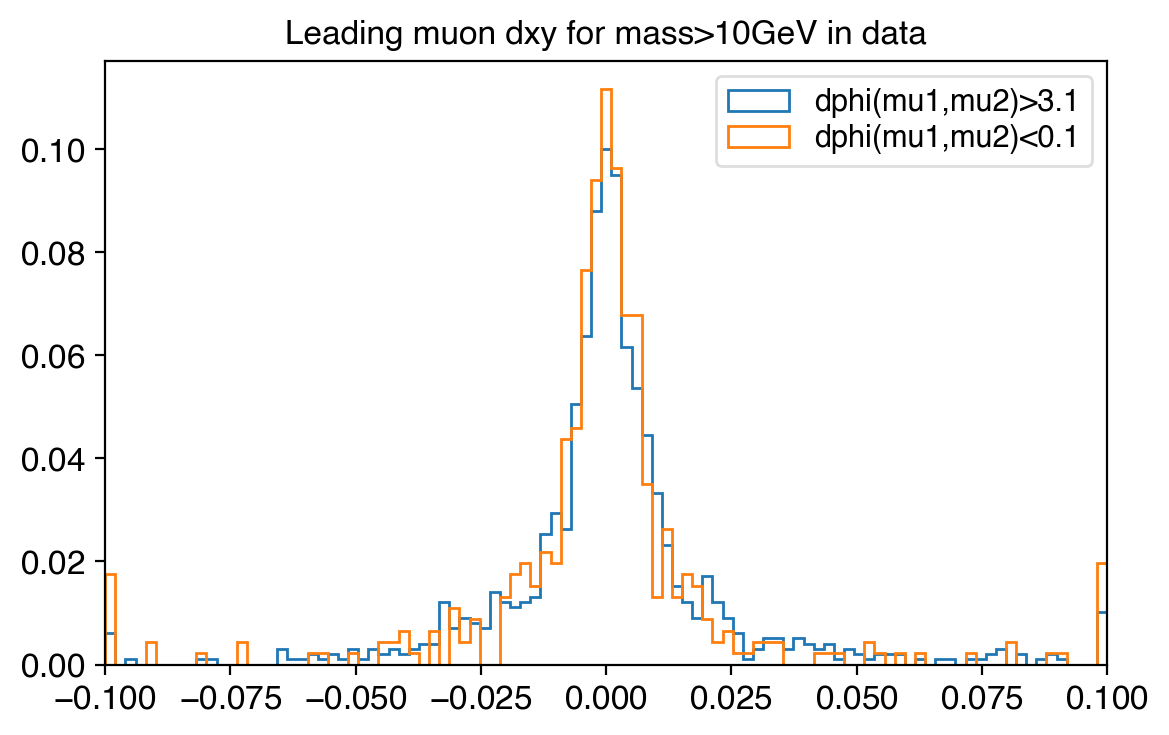

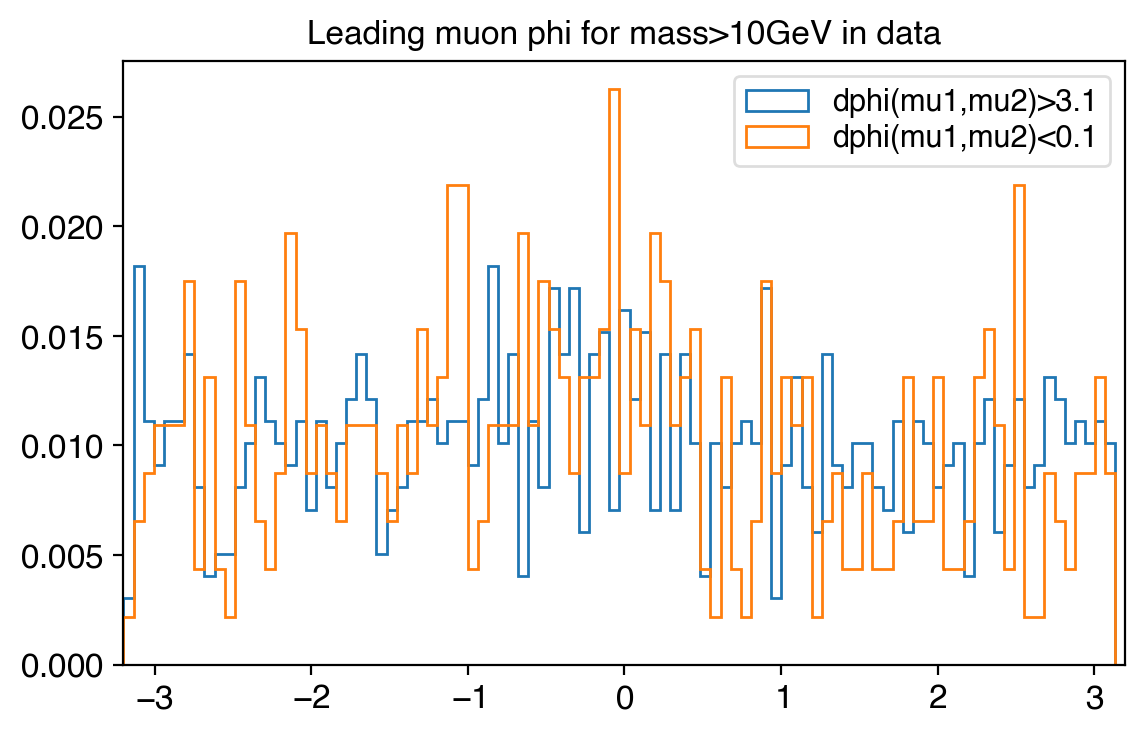

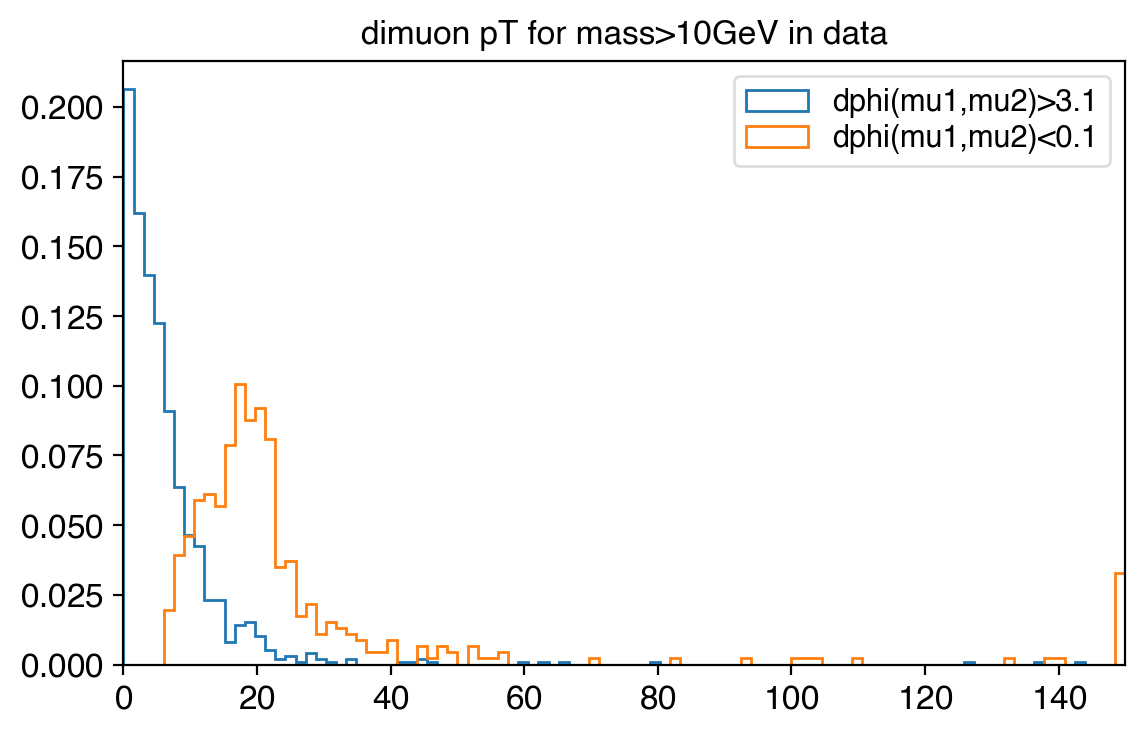

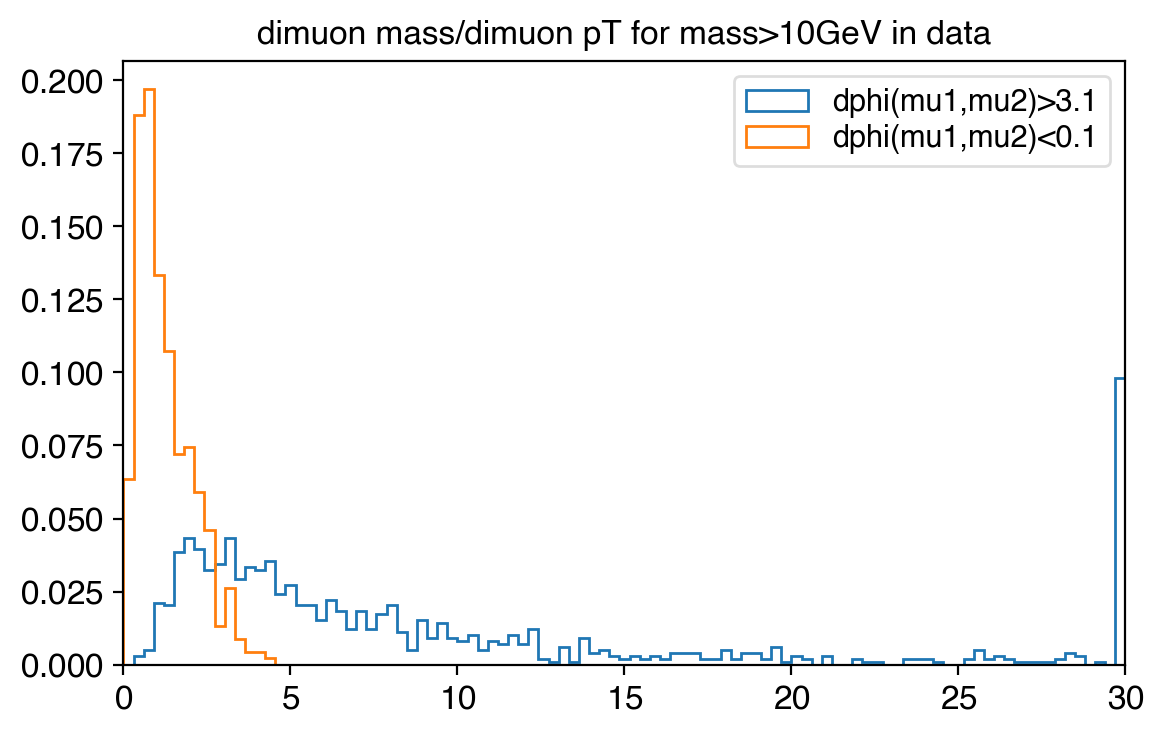

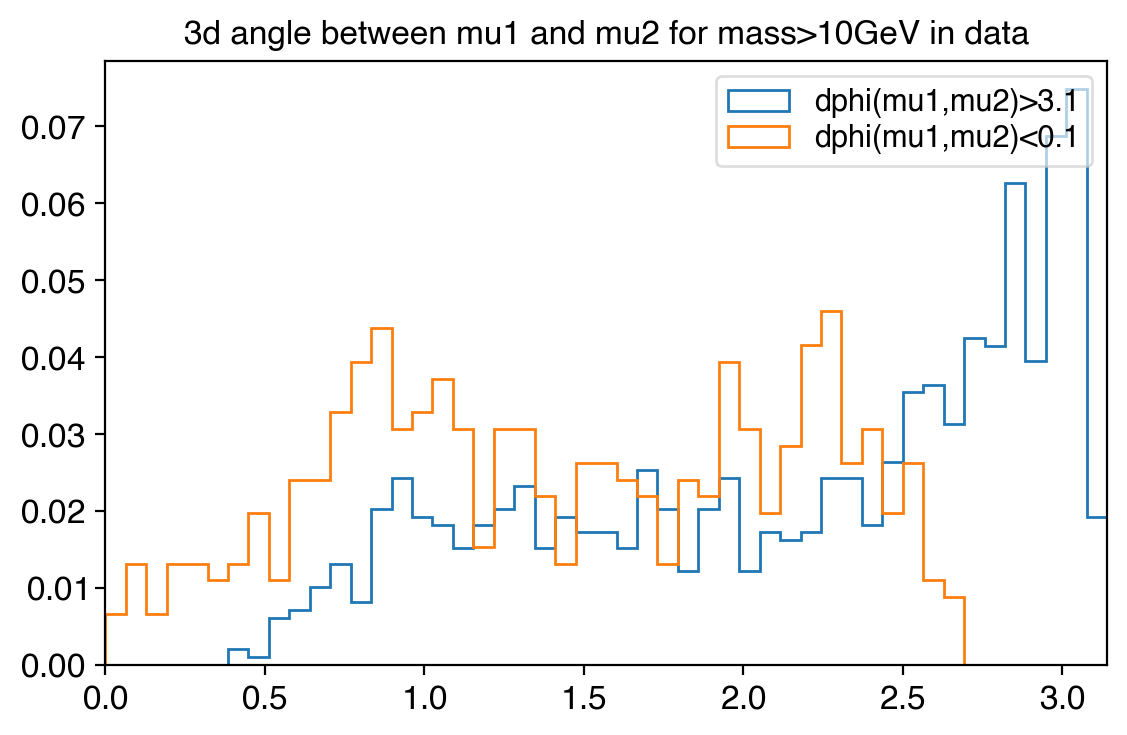

In [265]:
# Hist1D(df_data.query("absdphimumu > 3.1")["absdphimumu"],bins=np.linspace(0,np.pi,100)).plot()
!mkdir -p plots_misc_v2

fig, ax = plt.subplots()
Hist1D(df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")["Muon1_dxyCorr"],bins=np.linspace(-0.1,0.1,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)>3.1")
Hist1D(df_data.query("(dimuon_mass>10) and (absdphimumu < 0.1)")["Muon1_dxyCorr"],bins=np.linspace(-0.1,0.1,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
ax.set_title("Leading muon dxy for mass>10GeV in data")
fig.savefig("plots_misc_v2/leadingmuondxy_splitphi_mass10.png")

fig, ax = plt.subplots()
Hist1D(df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")["Muon1_phi"],bins=np.linspace(-3.2,3.2,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)>3.1")
Hist1D(df_data.query("(dimuon_mass>10) and (absdphimumu < 0.1)")["Muon1_phi"],bins=np.linspace(-3.2,3.2,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
ax.set_title("Leading muon phi for mass>10GeV in data")
fig.savefig("plots_misc_v2/leadingphi_splitphi_mass10.png")

fig, ax = plt.subplots()
df1 = df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")
df2 = df_data.query("(dimuon_mass>10) and (absdphimumu < 0.1)")
Hist1D(df1["dimuon_pt"],bins=np.linspace(0,150.,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)>3.1")
Hist1D(df2["dimuon_pt"],bins=np.linspace(0,150.,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
ax.set_title("dimuon pT for mass>10GeV in data")
fig.savefig("plots_misc_v2/pt_splitphi_mass10.png")

fig, ax = plt.subplots()
df1 = df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")
df2 = df_data.query("(dimuon_mass>10) and (absdphimumu < 0.1)")
Hist1D(df1["dimuon_mass"]/df1["dimuon_pt"],bins=np.linspace(0,30.,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)>3.1")
Hist1D(df2["dimuon_mass"]/df2["dimuon_pt"],bins=np.linspace(0,30.,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
ax.set_title("dimuon mass/dimuon pT for mass>10GeV in data")
fig.savefig("plots_misc_v2/massoverpt_splitphi_mass10.png")

fig, ax = plt.subplots()
df1 = df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")
df2 = df_data.query("(dimuon_mass>10) and (absdphimumu < 0.1)")
Hist1D(df1["angle3dmumu"],bins=np.linspace(0,3.142,50)).normalize().plot(histtype="step",label="dphi(mu1,mu2)>3.1")
Hist1D(df2["angle3dmumu"],bins=np.linspace(0,3.142,50)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
ax.set_title("3d angle between mu1 and mu2 for mass>10GeV in data")
fig.savefig("plots_misc_v2/angle3dmumu_splitphi_mass10.png")

!niceplots plots_misc_v2

# Hist1D(df_data.query("absdphimumu > 3.1")["Muon2_dxyCorr"],bins=np.linspace(0,0.1,100)).plot()
# Hist1D(df_data.query("absdphimumu < 0.1")["Muon1_dxyCorr"],bins=np.linspace(0,0.1,100)).plot()

# Hist1D(df_data.query("absdphimumu > 3.1")["Muon1_phi"],bins=np.linspace(-3.142,3.142,50)).normalize().plot()
# Hist1D(df_data.query("absdphimumu < 0.1")["Muon1_phi"],bins=np.linspace(-3.142,3.142,50)).normalize().plot()
# Hist1D(df_data.query("absdphimumu > 3.1")["Muon1_eta"],bins=np.linspace(-3.142,3.142,50)).normalize().plot()
# Hist1D(df_data.query("absdphimumu < 0.1")["Muon1_eta"],bins=np.linspace(-3.142,3.142,50)).normalize().plot()

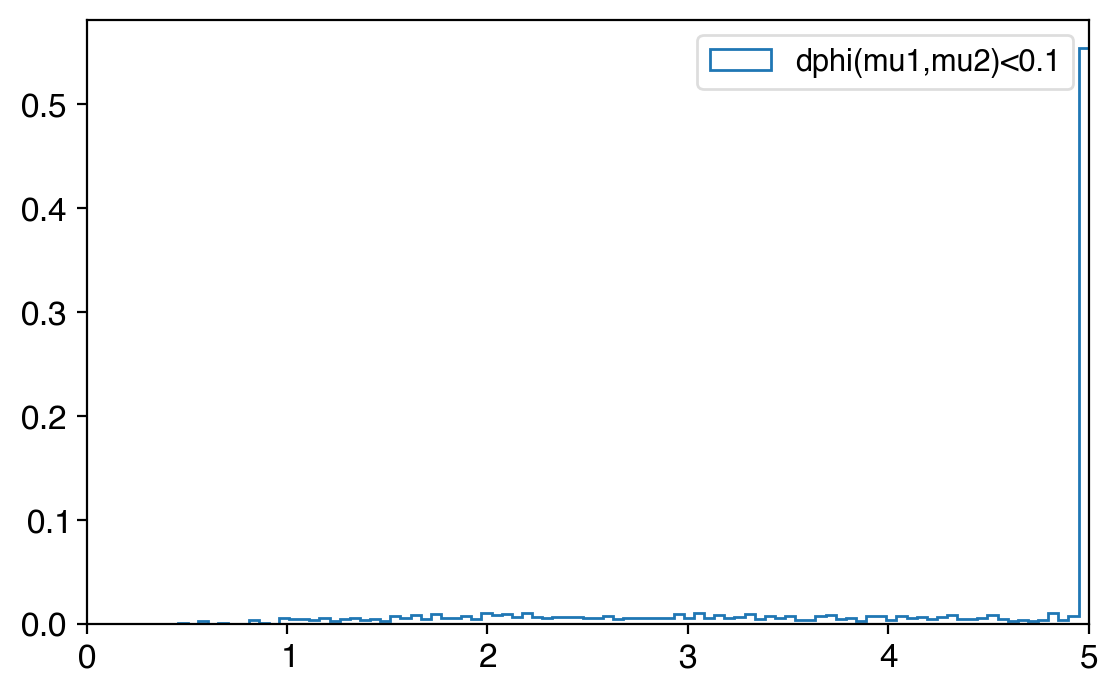

In [201]:
fig, ax = plt.subplots()
df = df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1)")
Hist1D(df["dimuon_mass"]/df["dimuon_pt"],bins=np.linspace(0.0,5.0,100)).normalize().plot(histtype="step",label="dphi(mu1,mu2)<0.1")
ax.legend()
# ax.set_title("Leading muon dxy for mass>10GeV in data")
# fig.savefig("plots_misc_v2/leadingmuondxy_splitphi_mass10.png")

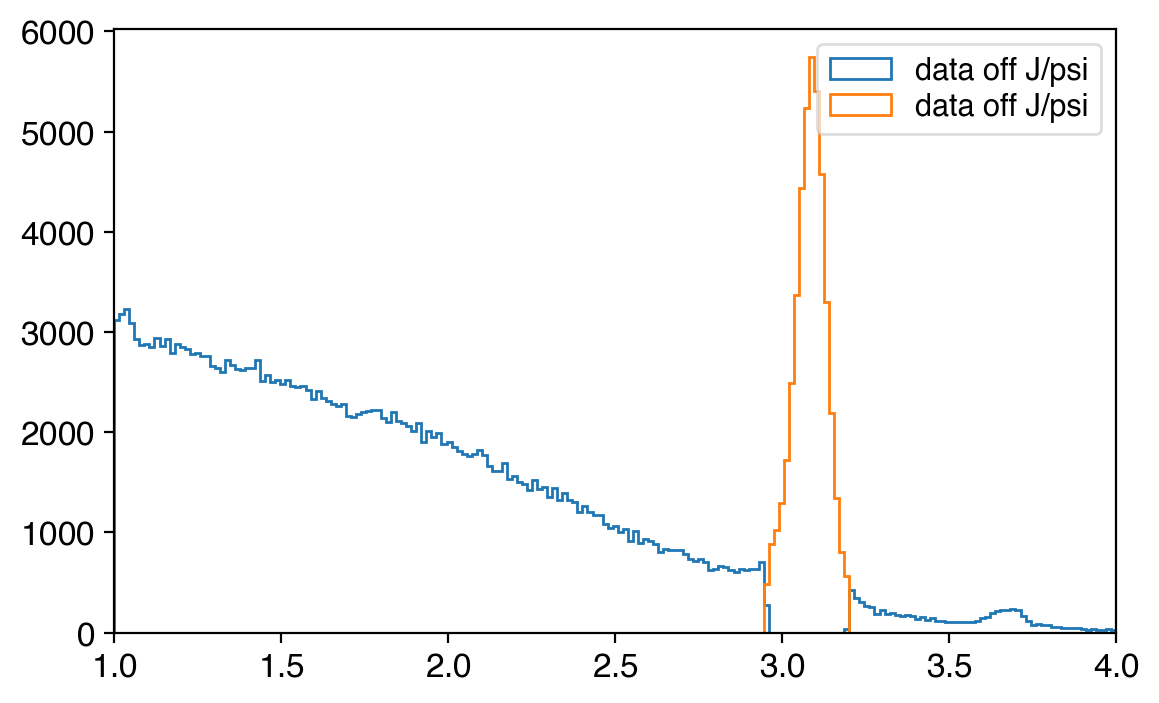

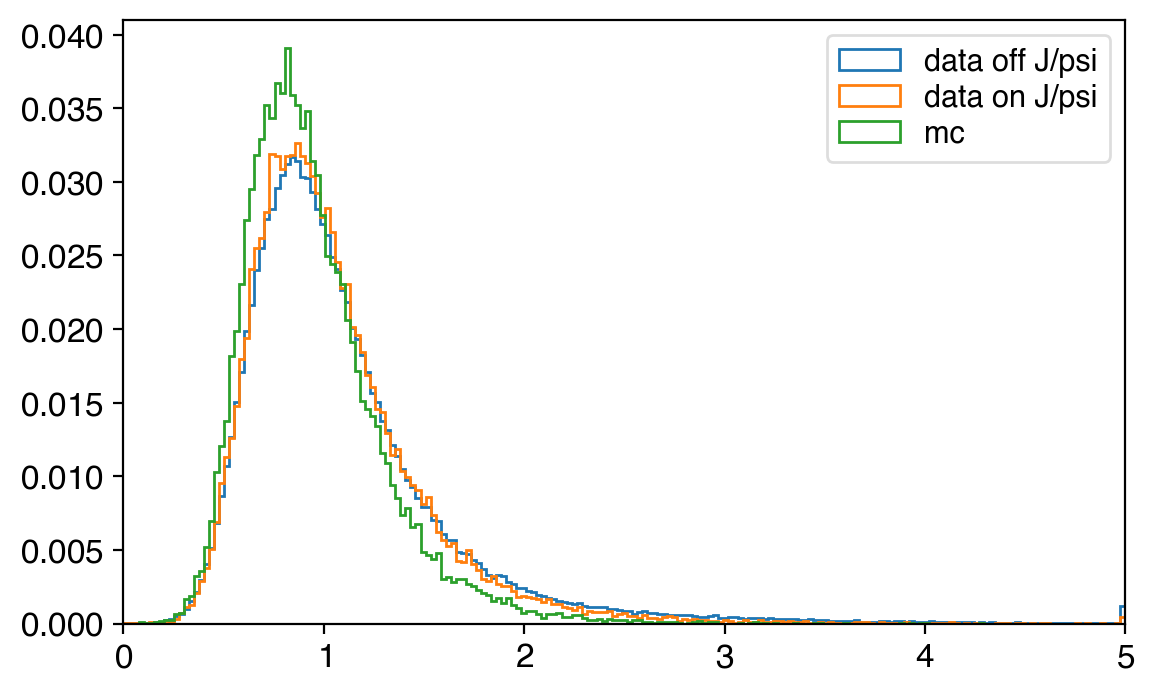

In [165]:
df_off = df_data.query("(1<dimuon_mass<4) and not (2.95<dimuon_mass<3.2)")
df_on = df_data.query("(2.95<dimuon_mass<3.2)")

fig, ax = plt.subplots()
Hist1D(df_off["dimuon_mass"],bins=np.linspace(1,4,200)).plot(label="data off J/psi",histtype="step")
Hist1D(df_on["dimuon_mass"],bins=np.linspace(1,4,200)).plot(label="data off J/psi",histtype="step")
ax.legend()

fig, ax = plt.subplots()
Hist1D(df_off["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data off J/psi")
Hist1D(df_on["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data on J/psi")
Hist1D(df_mc["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="mc")
ax.legend()

In [208]:
df = df_data
TLVA = uproot_methods.TLorentzVectorArray
mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)

In [222]:
dir(type(mu1.p3))
# mu2.p3

['AppendableArray',
 'BITMASKTYPE',
 'BOOLTYPE',
 'BitMaskedArray',
 'CHARTYPE',
 'ChunkedArray',
 'DEFAULTTYPE',
 'INDEXTYPE',
 'IndexedArray',
 'IndexedMaskedArray',
 'JaggedArray',
 'MASKTYPE',
 'MaskedArray',
 'Methods',
 'ObjectArray',
 'SparseArray',
 'StringArray',
 'TAGTYPE',
 'Table',
 'UnionArray',
 'VirtualArray',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_ufunc__',
 '__awkward_serialize__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__m

In [239]:
# ((lambda v:(v.x**2 + v.y**2 + v.z**2)**0.5)(mu1.p3) - mu1.p3.mag).min()
np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
# mu1.p3.mag

array([0.03494887, 0.2224673 , 0.17433901, ..., 0.07113832, 0.11060005,
       0.17879786], dtype=float32)

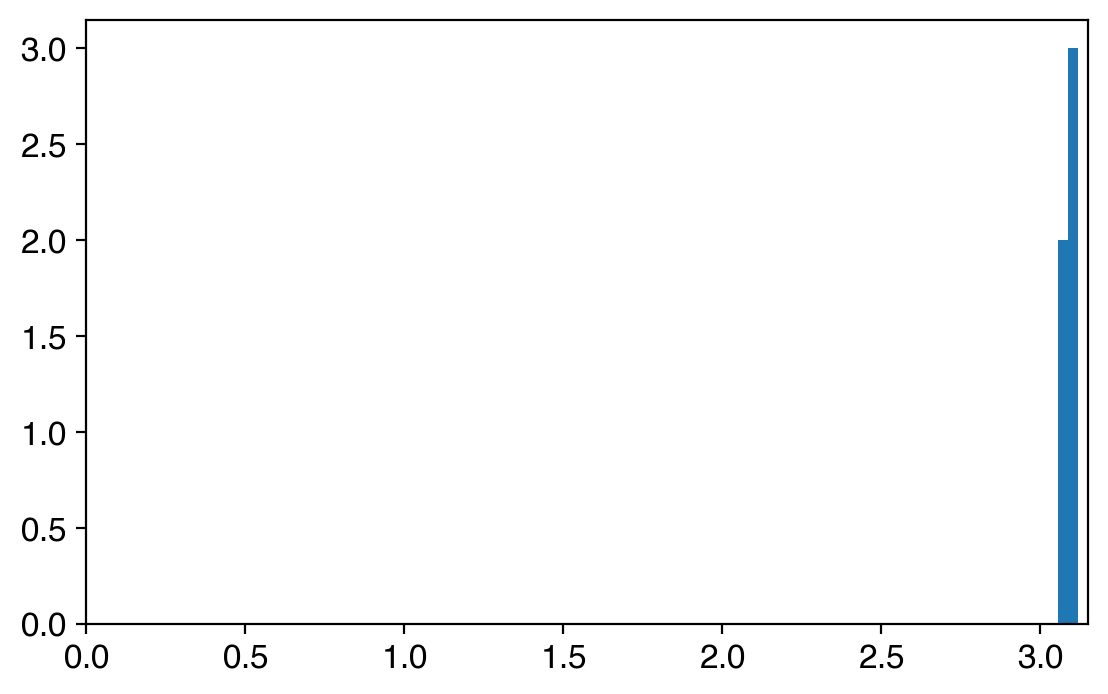

In [263]:
df = df_data.query("(dimuon_mass>10) and (absdphimumu > 3.1) and (Muon1_eta*Muon2_eta<0) and (abs(abs(Muon1_eta)-abs(Muon2_eta))<0.1)")
Hist1D(df["angle3dmumu"],bins=np.linspace(0,3.152,100)).plot()

In [264]:
df.filter(like="Muon")

,nMuon,nGenMuon,Muon1_pt,Muon2_pt,Muon1_eta,Muon2_eta,Muon1_phi,Muon2_phi,Muon1_m,Muon2_m,...,Muon1_vy,Muon2_vy,Muon1_vz,Muon2_vz,Muon1_dxyCorr,Muon2_dxyCorr,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt
283,2,0,10.229900,9.107698,-1.990682,1.894577,-2.323156,0.819313,0.10566,0.10566,...,-2.938558,-2.938558,-14.674556,-14.674556,0.009002,-0.005559,0.931028,0.628235,0.019184,0.020461
9724,2,0,26.427507,7.328184,0.486124,-0.561689,-1.618427,1.485258,0.10566,0.10566,...,-1.096433,-1.096433,-2.869191,-2.869191,-0.044101,0.004861,1.181496,0.355889,0.010286,0.009108
138105,2,0,13.634751,11.782151,0.837997,-0.776518,2.922236,-0.251423,0.10566,0.10566,...,0.227460,0.227460,-2.195636,-2.195636,-0.037822,0.000152,1.194464,0.995934,0.010520,0.011553
223051,2,0,14.054744,13.533070,-0.704780,0.782026,1.630823,-1.517360,0.10566,0.10566,...,1.661561,1.661561,-4.747441,-4.747441,-0.052692,0.041310,1.235404,1.573551,0.009775,0.010479
338315,2,0,11.690154,5.184030,-1.540152,1.635417,1.967195,-1.176310,0.10566,0.10566,...,2.425665,2.425665,-4.324539,-4.324539,0.008009,-0.013178,0.734249,0.899389,0.015995,0.013907
